# Emotion Detection from Audio Signals Using LSTM Networks

This notebook demonstrates how to build a deep learning model that identifies human emotions from audio signals. The system classifies speech into six emotion categories: happiness, sadness, neutrality, fear, anger, and disgust.

## Workflow Overview
1. Data collection and integration
2. Exploratory data analysis
3. Audio preprocessing
4. Acoustic feature extraction
5. LSTM model construction
6. Performance evaluation

## Data Sources
This project utilizes multiple publicly available audio emotion datasets:
* Crema-D (multimodal emotion database)
* Ravdess (audio-visual emotion recognition)
* Savee (speaker-dependent emotion)
* Tessa (emotional speech)
* EmoDB (Berlin emotional speech database)

## 1. Data Collection and Integration

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import random

os.environ['PYTHONHASHSEED'] = '1'
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

In [2]:
RAVDESS = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
CREMA = "/kaggle/input/cremad/AudioWAV/"
TESS = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
SAVEE = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"
EMODB = "/kaggle/input/berlin-database-of-emotional-speech-emodb/wav/"

**1. Ravdess Dataframe**

There are 1440 audio files, for example, 03-01-**06**-01-02-01-12.wav.

In [3]:
ravdess_directory_list = os.listdir(RAVDESS)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    '03' : 'happy',
    '01' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fear',
    '07' : 'disgust',
}

for directory in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(RAVDESS, directory))
    for audio_file in actor_files: 
        part = audio_file.split('.')[0]
        code = part.split('-')[2]
        if code in code_to_emotion:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{audio_file}")
            gender_list.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(code_to_emotion[code])
            
ravdess = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

ravdess.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


**2. Crema-D Dataframe**

There are 7,442 audio files, for example, 1001_DFA_**ANG**_XX.wav.

In [4]:
crema_directory_list = os.listdir(CREMA)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    'HAP' : 'happy',
    'NEU' : 'neutral',
    'SAD' : 'sad',
    'ANG' : 'angry',
    'FEA' : 'fear',
    'DIS' : 'disgust',
}

female_id_set = {
    '1002', '1003', '1004', '1006', '1007', '1008', '1009', '1010', '1012', '1013', '1018', 
    '1020', '1021', '1024', '1025', '1028', '1029', '1030', '1037', '1043', '1046', '1047', 
    '1049', '1052', '1053', '1054', '1055', '1056', '1058', '1060', '1061', '1063', '1072', 
    '1073', '1074', '1075', '1076', '1078', '1079', '1082', '1084', '1089', '1091',
}

for audio_file in crema_directory_list:
    part = audio_file.split('_')
    code = part[2]
    if code in code_to_emotion and part[3] == 'HI.wav':
        path_list.append(f"{CREMA}{audio_file}")
        gender_list.append('female' if part[0] in female_id_set else 'male')
        emotion_list.append(code_to_emotion[code])

crema = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

crema.head()

,path,sex,emotion
0,/kaggle/input/cremad/AudioWAV/1032_IEO_HAP_HI.wav,male,happy
1,/kaggle/input/cremad/AudioWAV/1076_IEO_FEA_HI.wav,female,fear
2,/kaggle/input/cremad/AudioWAV/1056_IEO_ANG_HI.wav,female,angry
3,/kaggle/input/cremad/AudioWAV/1038_IEO_SAD_HI.wav,male,sad
4,/kaggle/input/cremad/AudioWAV/1043_IEO_DIS_HI.wav,female,disgust


**3. Tess Dataframe**

There are 2,800 audio files, for example, OAF_base_**fear**.wav.

In [5]:
tess_dir_list = os.listdir(TESS)
path_list = []
gender_list = []
emotion_list = [] 

code_to_emotion = {
    'happy'   : 'happy',
    'neutral' : 'neutral',
    'sad'     : 'sad',
    'Sad'     : 'sad',
    'angry'   : 'angry',
    'fear'    : 'fear',
    'disgust' : 'disgust',
}

for directory in tess_dir_list:
    audio_files = os.listdir(os.path.join(TESS, directory))
    for audio_file in audio_files:
        part = audio_file.split('.')[0]
        code = part.split('_')[2]
        if code in code_to_emotion:
            path_list.append(f"{TESS}{directory}/{audio_file}") 
            gender_list.append('female') # female only dataset
            emotion_list.append(code_to_emotion[code])
            
tess = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

tess.head()

,path,sex,emotion
0,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,female,fear


**4. Savee Dataframe**

There are 480 audio files, for example, DC_**a**02.wav.

In [6]:
savee_directory_list = os.listdir(SAVEE)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    'h'  : 'happy',
    'n'  : 'neutral',
    'sa' : 'sad',
    'a'  : 'angry',
    'f'  : 'fear',
    'd'  : 'disgust'
}

for audio_file in savee_directory_list:
    part = audio_file.split('_')[1]
    code = part[:-6]
    if code in code_to_emotion:
        path_list.append(f"{SAVEE}{audio_file}")
        gender_list.append('male')
        emotion_list.append(code_to_emotion[code])
        
savee = pd.concat([
    pd.DataFrame(path_list, columns=['path']),
    pd.DataFrame(gender_list, columns=['sex']),
    pd.DataFrame(emotion_list, columns=['emotion'])
], axis=1)

savee.head()

,path,sex,emotion
0,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
1,/kaggle/input/surrey-audiovisual-expressed-emo...,male,fear
2,/kaggle/input/surrey-audiovisual-expressed-emo...,male,happy
3,/kaggle/input/surrey-audiovisual-expressed-emo...,male,disgust
4,/kaggle/input/surrey-audiovisual-expressed-emo...,male,angry


**5. EmoDB Dataframe**

There are 535 audio files, for example, 03a01**F**a.wav.

In [7]:
emodb_directory_list = os.listdir(EMODB)
path_list = []
gender_list = []
emotion_list = []

code_to_emotion = {
    'W' : 'angry',
    'E' : 'disgust', 
    'A' : 'fear', 
    'F' : 'happy', 
    'T' : 'sad', 
    'N' : 'neutral'
}

female_id_set = {
    '08', '09', '13', '14', '16'
}

print(emodb_directory_list[0].split('.')[0][0:2])

for audio_file in emodb_directory_list:
    part = audio_file.split('.')[0]
    code = part[-2]
    if code in code_to_emotion: 
        path_list.append(f"{EMODB}{audio_file}")
        gender_list.append('female' if part[0:2] in female_id_set else 'male')
        emotion_list.append(code_to_emotion[code])

emodb = pd.concat([
    pd.DataFrame(path_list, columns=['path']), 
    pd.DataFrame(gender_list, columns=['sex']), 
    pd.DataFrame(emotion_list, columns=['emotion']), 
], axis=1)

emodb.head()

15


,path,sex,emotion
0,/kaggle/input/berlin-database-of-emotional-spe...,male,happy
1,/kaggle/input/berlin-database-of-emotional-spe...,female,happy
2,/kaggle/input/berlin-database-of-emotional-spe...,female,angry
3,/kaggle/input/berlin-database-of-emotional-spe...,male,angry
4,/kaggle/input/berlin-database-of-emotional-spe...,female,angry


In [8]:
df = pd.concat([
    ravdess, 
    crema, 
    tess, 
    savee, 
    emodb
], axis=0)
df.head()

,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


# 2. Quick EDA

We check for imbalances like male to female ratio. 

In [9]:
import librosa
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [10]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4785 entries, 0 to 453
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   path     4785 non-null   object
 1   sex      4785 non-null   object
 2   emotion  4785 non-null   object
dtypes: object(3)
memory usage: 149.5+ KB


,path,sex,emotion
0,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
1,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
2,/kaggle/input/ravdess-emotional-speech-audio/a...,female,disgust
3,/kaggle/input/ravdess-emotional-speech-audio/a...,female,neutral
4,/kaggle/input/ravdess-emotional-speech-audio/a...,female,fear


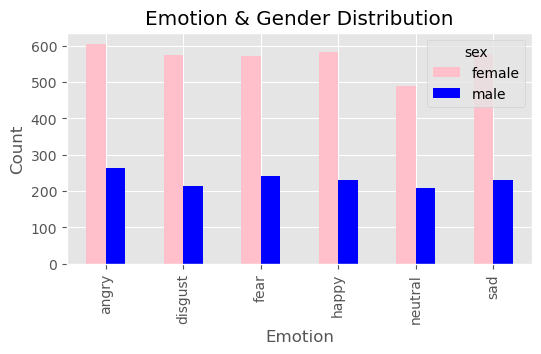

In [11]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'sex']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='sex', values='path')

    pivotTable.plot(kind='bar', figsize=(6, 3), color=['pink', 'blue'])
    plt.title('Emotion & Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(df)

Slight imbalances, but I think we have enough data. Let's see some sample data. 

In [12]:
from IPython.display import Audio

def create_waveplot(y, sr, title):
    plt.figure(figsize=(8, 2))
    plt.title(title)
    librosa.display.waveshow(y, sr=sr)
    plt.show()

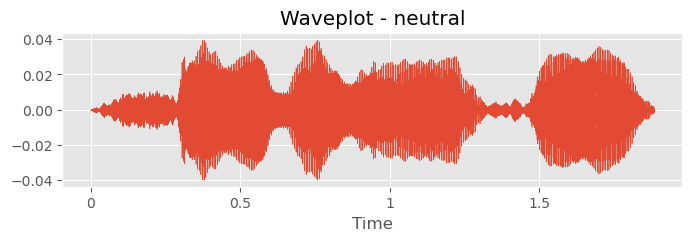

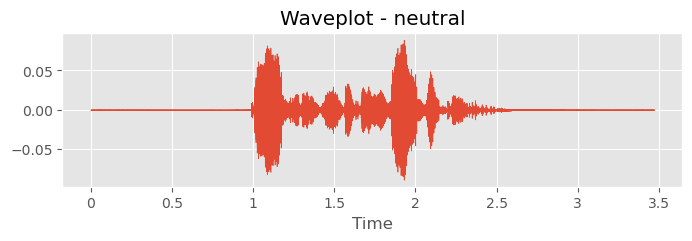

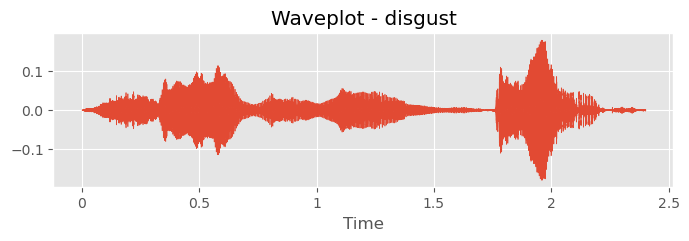

In [13]:
sample_size = 3
sample = df.sample(n=sample_size, random_state=1)

for idx, row in sample.iterrows():
   emotion = row['emotion']
   path = row['path']
   
   y, sr = librosa.load(path)
   create_waveplot(y, sr, f"Waveplot - {emotion}")
   
   display(Audio(path))
   print("\n")

# 3. Preprocess

The following steps will be followed to preprocess the audio: 

1. Sample Rate
2. Trimming  
3. Padding

In [14]:
from pydub import AudioSegment, effects

In [15]:
def preprocess_audio(path):
    _, sr = librosa.load(path)
    raw_audio = AudioSegment.from_file(path)
    
    samples = np.array(raw_audio.get_array_of_samples(), dtype='float32')
    trimmed, _ = librosa.effects.trim(samples, top_db=25)
    padded = trimmed[:180000] if len(trimmed) > 180000 else np.pad(trimmed, (0, 180000-len(trimmed)), 'constant')
    return padded, sr

Audio segments are standardized to approximately 8 seconds in duration. Given that typical speech utterances span 2-4 seconds, the pipeline adds approximately 4-6 seconds of uniform padding to achieve consistent sequence lengths across the training set.

In [16]:
emotion_to_code = {
    'neutral' : 0,
    'happy'   : 1,
    'sad'     : 2, 
    'angry'   : 3, 
    'fear'    : 4, 
    'disgust' : 5
}

code_to_emotion = {v : k for k, v in emotion_to_code.items()}

def encode(label):
    return emotion_to_code.get(label)

def decode(encoded_label):
    return code_to_emotion.get(encoded_label) 

# 4. Extract features

We extract three features, using librosa (https://librosa.org/doc/latest/index.html):

1. Mel-Frequency Cepstral Coefficients (MFCC)
2. Zero Crossing Rate (ZCR)
3. Root Mean Square Energy (RMS)

But, before that, we should look at the hop length & the frame length. 

In [17]:
FRAME_LENGTH = 2048
HOP_LENGTH = 512

The hop length is set to 512 samples & the frame length is set to 2048 samples for consistency. The hop length is the size of the sliding window. Think of it as taking a "snapshot." The frame length is how many samples you "jump" forward between each window. In the diagram below:

* HOP_LENGTH: Q
* FRAME_LENGTH: K

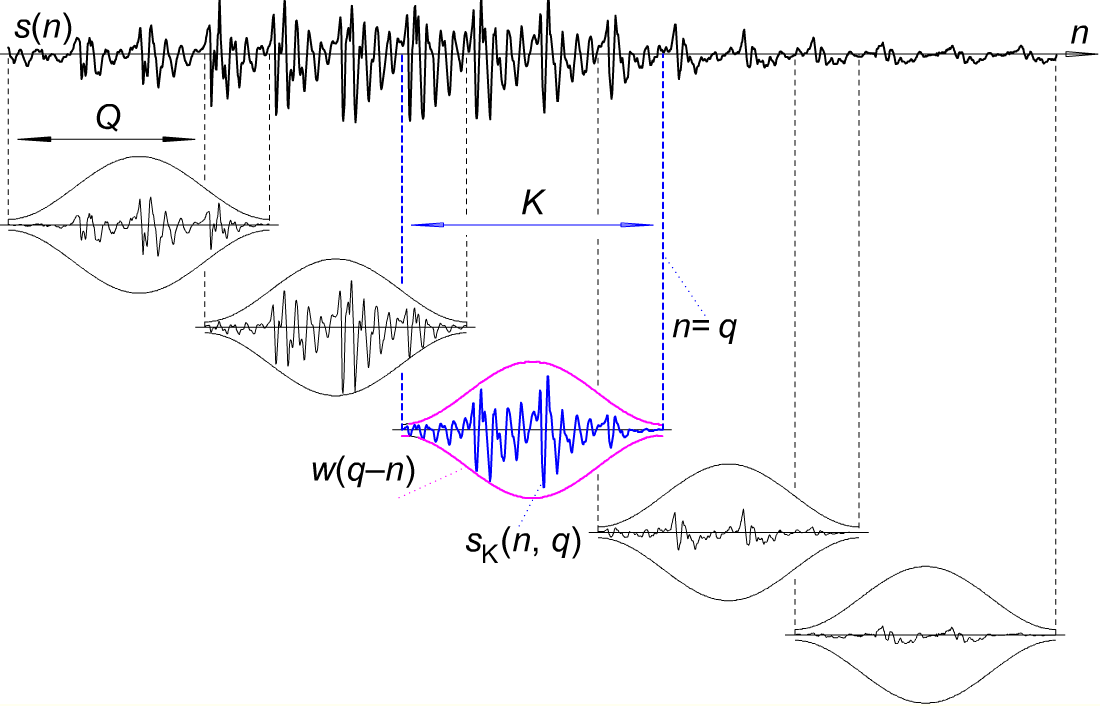

In [18]:
sample_idx=0
y,sr=preprocess_audio(df.iloc[sample_idx]['path'])
emotion=df.iloc[sample_idx]['emotion']

**1. Mel-Frequency Cepstral Coefficients (MFCC)**

MFCC coefficients represent acoustic features derived from the perceptually-weighted spectrum. The computation process includes: applying windowing functions to isolate temporal segments, computing the discrete Fourier transform, converting frequency representations to the mel scale based on human auditory perception, applying logarithmic scaling, and performing discrete cosine transformation. The resulting coefficients efficiently encode spectral envelope information. Thirteen MFCC dimensions are extracted per frame for model input.

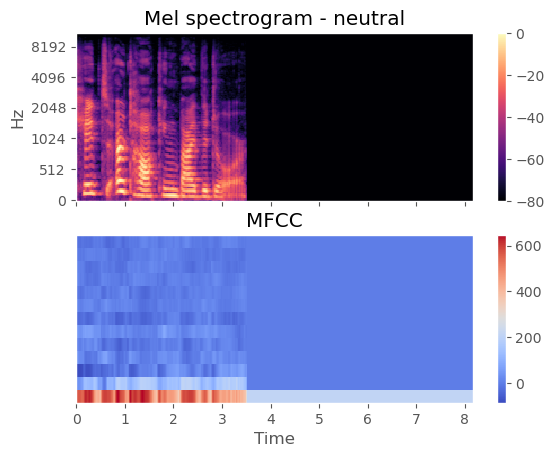

In [19]:
S = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=HOP_LENGTH)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)

fig,ax=plt.subplots(nrows=2, sharex=True)

img=librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title=f'Mel spectrogram - {emotion}')
ax[0].label_outer()

img = librosa.display.specshow(mfccs, x_axis='time', ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='MFCC')
plt.show()

**2. Zero Crossing Rate**

Zero crossing rate quantifies the frequency of amplitude sign changes in the waveform. Elevated ZCR characterizes high-frequency, noisy, or fricative-like components while lower ZCR corresponds to smooth, periodically-voiced segments such as vowel sounds. ZCR serves as a discriminative feature for articulation style and spectral content, particularly sensitive to emotion classes distinguished by prosodic quality.

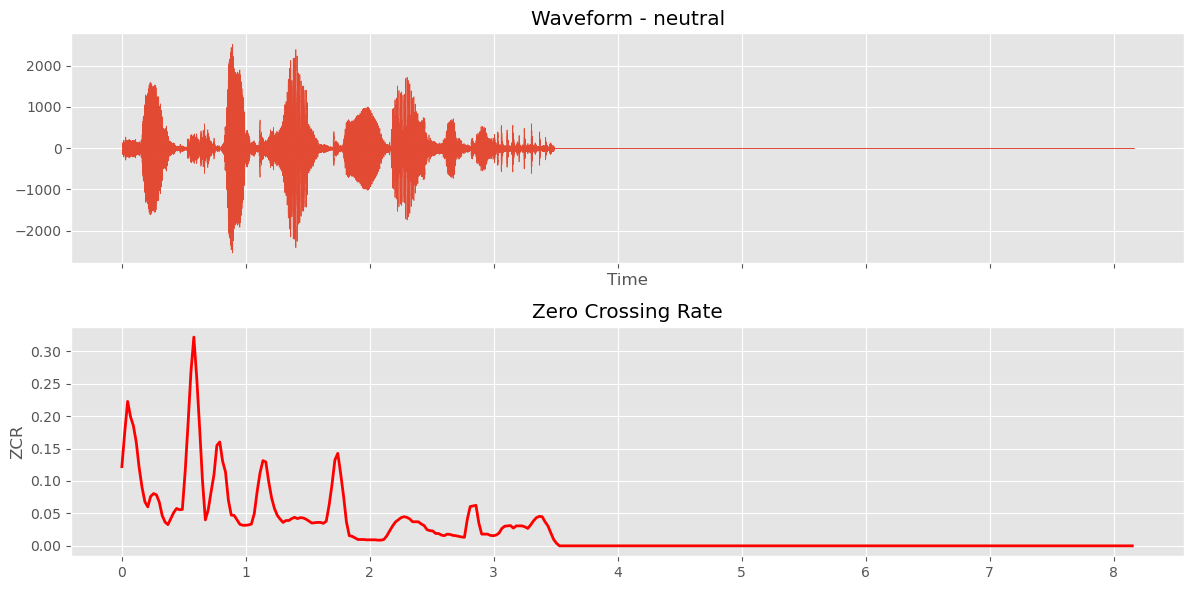

In [20]:
zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)[0]
times = librosa.frames_to_time(np.arange(len(zcr)), sr=sr, hop_length=HOP_LENGTH)

fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set(title=f'Waveform - {emotion}')
ax[1].plot(times, zcr, color='red', linewidth=2)
ax[1].set(title='Zero Crossing Rate', ylabel='ZCR')
plt.tight_layout()
plt.show()

**3. Root Mean Squared Energy**

RMS energy quantifies the acoustic power or temporal intensity envelope. Elevated RMS values characterize loud, forceful utterances with strong vocal exertion, while diminished RMS indicates softer, attenuated speech. RMS effectively discriminates between activation-level emotions exhibiting high energy expression (e.g., anger, elation) and deactivation-level emotions with reduced vocal intensity (e.g., melancholy, neutral states).

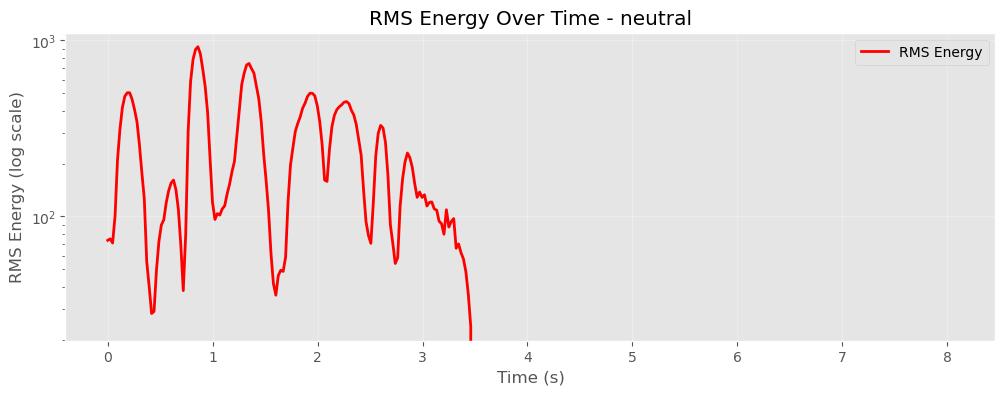

In [21]:
S = librosa.magphase(librosa.stft(y, window=np.ones, center=False, n_fft=FRAME_LENGTH, hop_length=HOP_LENGTH))[0]
rms = librosa.feature.rms(S=S)
times = librosa.times_like(rms)

plt.figure(figsize=(12, 4))
plt.semilogy(times, rms[0], label='RMS Energy', color='red', linewidth=2)
plt.title(f'RMS Energy Over Time - {emotion}')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy (log scale)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Shape of $X$: (samples, timesteps, features)
* samples: number of audio files
* timesteps: number of frames = 1 + floor(len(y) / HOP_LENGTH) = 352
* features: [zcr, rms, mfcc_1, mfcc_2, ..., mfcc_13] (total 15 features)

In [22]:
def extract_features(df):
    zcr_list = []
    rms_list = []
    mfccs_list = []
    emotion_list = []
    
    for row in df.itertuples(index=False):
        try: 
            y, sr = preprocess_audio(row.path)
    
            zcr = librosa.feature.zero_crossing_rate(y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            rms = librosa.feature.rms(y=y, frame_length=FRAME_LENGTH, hop_length=HOP_LENGTH)
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, hop_length=HOP_LENGTH)
    
            zcr_list.append(zcr)
            rms_list.append(rms)
            mfccs_list.append(mfccs)
    
            emotion_list.append(encode(row.emotion))
        except Exception as e:
            print(f"Failed for path: {row.path}")
            print(f"Error: {e}")
    
    X = np.concatenate((
        np.swapaxes(zcr_list, 1, 2), 
        np.swapaxes(rms_list, 1, 2), 
        np.swapaxes(mfccs_list, 1, 2)), 
        axis=2
    )
    X = X.astype('float32')
    
    y = np.asarray(emotion_list)
    y = np.expand_dims(y, axis=1).astype('int8')

    return X, y

Observable gender distribution asymmetry exists within the aggregated dataset. From a physiological and acoustic standpoint, sex-based differences in vocal tract morphology and speaking patterns justify developing gender-stratified models to optimize performance on each demographic subgroup.

In [23]:
df_female = df[df.sex == 'female'].copy()
df_male = df[df.sex == 'male'].copy()

In [24]:
X_female, y_female = extract_features(df_female)
X_male, y_male = extract_features(df_male)

In [25]:
print("Female: ")
print(X_female.shape)
print(y_female.shape)

print("Male: ")
print(X_male.shape)
print(y_male.shape)

Female: 
(3399, 352, 15)
(3399, 1)
Male: 
(1386, 352, 15)
(1386, 1)


Let's create a radar plot to validate these features, seeing how spectral & temporal patterns correlation with various emotions.

In [26]:
def extract_feature_statistics(feature_matrix: np.ndarray, 
                                emotion_labels: np.ndarray) -> pd.DataFrame:
    """
    Calculate mean values of acoustic features across time dimension.
    
    This function performs temporal aggregation of features by computing
    the mean value for each acoustic feature across all time steps. This
    produces a feature vector for each audio sample that represents the
    average acoustic characteristics over the entire utterance duration.
    
    Args:
        feature_matrix (np.ndarray): Input features with shape (n_samples, n_timesteps, n_features)
        emotion_labels (np.ndarray): Emotion codes with shape (n_samples, 1)
        
    Returns:
        pd.DataFrame: DataFrame with rows=samples and columns=[ZCR, RMS, MFCC1-13, emotion]
                     The emotion column contains human-readable emotion labels
                     
    Process:
        1. Compute temporal mean for each feature across timesteps (axis=1)
        2. Organize feature means into a DataFrame with descriptive column names
        3. Decode emotion indices back to string labels for interpretability
        4. Return DataFrame suitable for statistical analysis or visualization
    """
    # Compute mean feature values across time dimension
    temporal_feature_means = np.mean(feature_matrix, axis=1)
    
    # Create feature names: ZCR, RMS, and MFCC 1-13
    acoustic_feature_names = ['ZCR', 'RMS'] + [f'MFCC{i}' for i in range(1, 14)]
    
    # Create DataFrame from mean values
    feature_statistics_df = pd.DataFrame(temporal_feature_means, columns=acoustic_feature_names)
    
    # Add emotion labels using decoding function for human readability
    feature_statistics_df['emotion'] = [
        decode_emotion_label(emotion_code) 
        for emotion_code in emotion_labels.flatten()
    ]
    
    return feature_statistics_df

# Extract and compute statistics for both male and female subsets
df_female_statistics = extract_feature_statistics(X_female, y_female)
df_male_statistics = extract_feature_statistics(X_male, y_male)

print("Female Speaker Feature Statistics:")
print(df_female_statistics.head())
print("\nMale Speaker Feature Statistics:")
print(df_male_statistics.head())

Female Means DF: 
        ZCR         RMS       MFCC1      MFCC2      MFCC3      MFCC4  \
0  0.024746  105.464600  341.499054  60.648106   0.453078   6.618733   
1  0.038538  202.757462  435.621185  66.627693  -4.630603  11.763195   
2  0.028080   89.618889  329.838989  63.908962  -5.549635  10.375246   
3  0.030774  167.918198  392.446991  60.254528   1.747526   7.338648   
4  0.039638  560.247681  497.415894  38.340744 -13.715072   4.085318   

      MFCC5      MFCC6      MFCC7     MFCC8     MFCC9    MFCC10    MFCC11  \
0 -1.448189  10.790609  -7.324445  2.443778 -1.125623  0.590647 -2.630092   
1  2.102120   7.215371  -8.628454 -0.264839 -0.279486  2.216101 -3.050270   
2  2.407283   7.663542  -6.799921  2.485309  0.151874  1.985165 -2.556408   
3 -1.996967   9.588508  -7.774040  1.245252 -1.627656  0.225617 -2.658981   
4 -9.474839   6.421329 -10.930285 -4.409543 -4.861330 -2.544556 -7.696184   

     MFCC12    MFCC13  emotion  
0 -2.663263 -2.021348  neutral  
1 -1.429288 -1.92360

Let's use a simple boxplot to identify outliers, but note simple IQR tests may be insufficient since we are assuming normal distributions. We could manually investigate these outliers. 

Female: 
n = 3399
Feature: ZCR. Outlier Count: 53
Feature: RMS. Outlier Count: 203
Feature: MFCC1. Outlier Count: 35
Feature: MFCC2. Outlier Count: 333
Feature: MFCC3. Outlier Count: 30
Feature: MFCC4. Outlier Count: 51


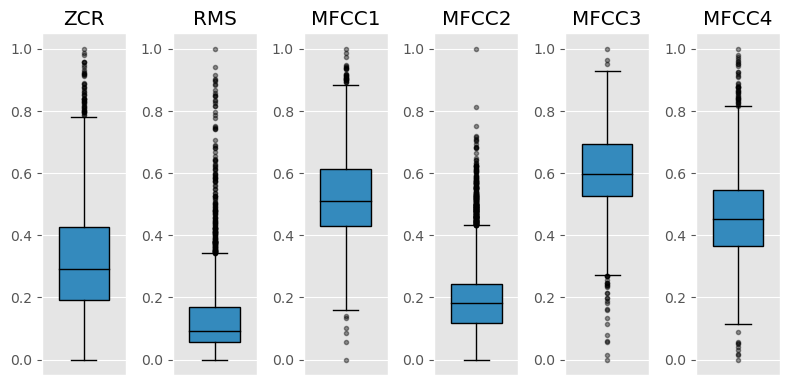

Male: 
n = 1386
Feature: ZCR. Outlier Count: 36
Feature: RMS. Outlier Count: 122
Feature: MFCC1. Outlier Count: 0
Feature: MFCC2. Outlier Count: 0
Feature: MFCC3. Outlier Count: 93
Feature: MFCC4. Outlier Count: 2


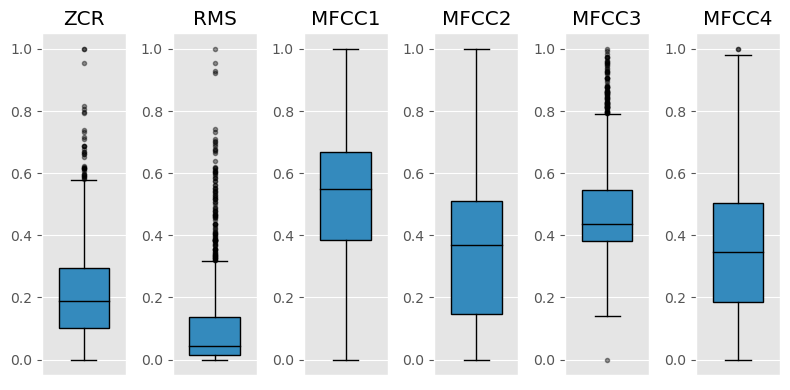

In [27]:
from sklearn.preprocessing import MinMaxScaler

def identify_outliers(df):
    print(f'n = {len(df)}')
    
    feature_names = ['ZCR', 'RMS'] + [f'MFCC{i}' for i in range(1, 5)]

    scaler = MinMaxScaler()
    df = pd.DataFrame(scaler.fit_transform(df[feature_names]), columns=feature_names, index=df.index)

    n = len(feature_names)
    fig, axs = plt.subplots(1, n, figsize=(8, 4)) 

    for i in range(n):
        feature_name = feature_names[i]
        
        Q1 = df[feature_name].quantile(0.25)
        Q3 = df[feature_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outlier_mask = (df[feature_name] < lower_bound) | (df[feature_name] > upper_bound)
        print(f'Feature: {feature_name}. Outlier Count: {outlier_mask.sum()}')
        
        axs[i].boxplot(
            df[feature_name], 
            patch_artist=True, 
            widths=0.6, 
            medianprops=dict(color='black'), 
            flierprops=dict(markerfacecolor='black', marker='o', markersize=3, alpha=0.4)
        )
        axs[i].set_title(feature_name)
        axs[i].set_xticks([])

    plt.tight_layout()
    plt.show()

print("Female: ")
identify_outliers(df_female_means)

print("Male: ")
identify_outliers(df_male_means)

MFCC2 for females warrants an investigation.

Females: 


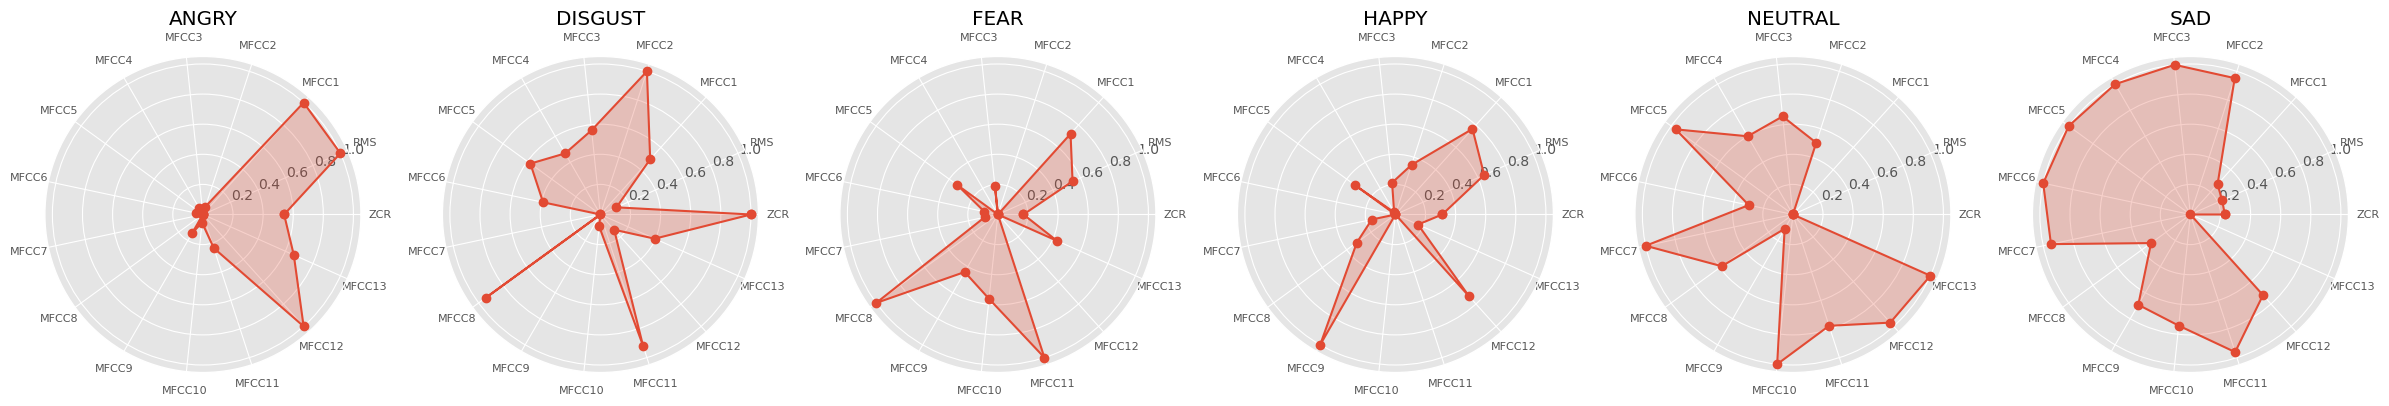

Males: 


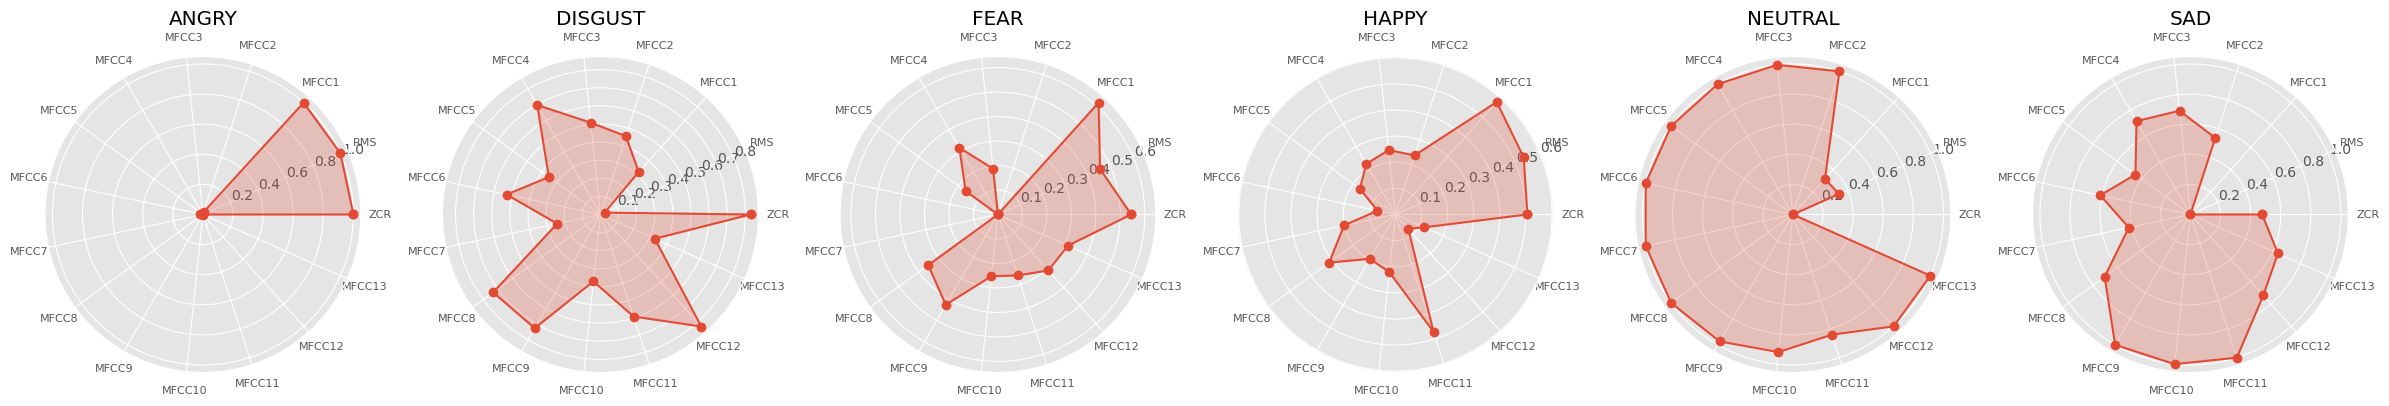

In [28]:
def radar_plot(df):
    means = df.groupby('emotion').mean()
    scaler = MinMaxScaler()
    normalized = pd.DataFrame(scaler.fit_transform(means), index=means.index, columns=means.columns)
    
    n = len(normalized)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4), subplot_kw={'polar': True})
    
    angles = np.append(np.linspace(0, 2*np.pi, len(normalized.columns), False), 0)
    
    for i, (emotion, row) in enumerate(normalized.iterrows()):
        vals = np.append(row.values, row.values[0])
        axs[i].plot(angles, vals, 'o-')
        axs[i].fill(angles, vals, alpha=0.25)
        axs[i].set_xticks(angles[:-1])
        axs[i].set_xticklabels(normalized.columns, fontsize=8)
        axs[i].set_title(emotion.upper())
    
    plt.tight_layout()
    plt.show()

print("Females: ")
radar_plot(df_female_means)

print("Males: ")
radar_plot(df_male_means)

We can see many patterns: 
* High-energy emotions like angry is associated with high RMS, ZCR & MFCC1. 
* Calm emotions like neutral & sad emotions result with lower RMS & ZCR.
* ZCR seems to be a strong indicator for disgust.
* Females show the most distinctive spectral patterns in sad speech (high mfccs).
* So on ...

The most important observation is that we probably will not be able to get the same performance for the male model in comparison to the female model. Let's see if any of these differences in means are significant using the Kruskal test, since distributions are probably not normal (from boxplots).

In [29]:
from scipy.stats import mannwhitneyu

feature_names = ['ZCR', 'RMS'] + [f'MFCC{i}' for i in range(1, 14)]

for feature_name in feature_names:
    _, p = mannwhitneyu(df_female_means[feature_name], df_male_means[feature_name])
    print(f'Feature: {feature_name}. p-value: {p}')

Feature: ZCR. p-value: 5.599245597081187e-170
Feature: RMS. p-value: 1.706169678466896e-39
Feature: MFCC1. p-value: 6.307735307006657e-51
Feature: MFCC2. p-value: 2.059495968034315e-202
Feature: MFCC3. p-value: 3.3650409719552624e-23
Feature: MFCC4. p-value: 8.409896649033506e-160
Feature: MFCC5. p-value: 6.602768836540658e-11
Feature: MFCC6. p-value: 1.7908748377199304e-160
Feature: MFCC7. p-value: 8.966181029694953e-163
Feature: MFCC8. p-value: 4.2433067979393006e-191
Feature: MFCC9. p-value: 6.8522057124644176e-189
Feature: MFCC10. p-value: 3.859164806554442e-60
Feature: MFCC11. p-value: 0.0
Feature: MFCC12. p-value: 2.908960720297613e-24
Feature: MFCC13. p-value: 0.0012370369971430547


## 5. Build a LSTM

Data organization is critical prior to model development. Recurrent neural networks are well-suited for sequence modeling tasks. Following the train-validation-test partitioning strategy, we develop gender-specific architectures to accommodate vocal characteristics particular to each demographic group.

In [30]:
from keras.models import Sequential
from keras import layers, optimizers, callbacks

In [31]:
def create_model():
    MODEL = Sequential()
    MODEL.add(layers.LSTM(64, return_sequences=True, input_shape=((352, 15))))
    MODEL.add(layers.LSTM(64))
    MODEL.add(layers.Dense(6, activation='softmax'))
    
    return MODEL 

model_female = create_model()
print("Female: ")
print(model_female.summary())

model_male = create_model()
print("Male: ")
print(model_male.summary())

Female: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 352, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 53,894
Trainable params: 53,894
Non-trainable params: 0
_________________________________________________________________
None
Male: 
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 352, 64)           20480     
                                                                 
 lstm_3 (

In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint 

In [33]:
def train(X, y, model, epochs, model_name):
    X_train, X_to_split, y_train, y_to_split = train_test_split(X, y, test_size=0.12, random_state=1)
    X_val, X_test, y_val, y_test = train_test_split(X_to_split, y_to_split, test_size=0.3, random_state=1)
    
    y_train_class = to_categorical(y_train, 6)
    y_val_class = to_categorical(y_val, 6)

    class_weights = compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train), 
        y=y_train.flatten()
    )

    checkpoint = ModelCheckpoint(
        model_name, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
    )
    
    model.compile(
        loss='categorical_crossentropy', 
        optimizer='RMSProp',
        metrics=['categorical_accuracy']
    )
    
    history = model.fit(
        X_train, 
        y_train_class, 
        epochs=epochs, 
        batch_size=6, 
        validation_data=(X_val, y_val_class), 
        class_weight=dict(enumerate(class_weights)), 
        # callbacks=checkpoint
    )

    return history, X_val, y_val

In [34]:
history_female, X_val_female, y_val_female = train(X_female, y_female, model_female, 200, 'model_female.h5')

Epoch 1/200
499/499 [==============================] - 40s 48ms/step - loss: 1.6424 - categorical_accuracy: 0.2905 - val_loss: 1.5935 - val_categorical_accuracy: 0.3228
Epoch 2/200
499/499 [==============================] - 23s 46ms/step - loss: 1.4602 - categorical_accuracy: 0.3848 - val_loss: 1.5418 - val_categorical_accuracy: 0.3579
Epoch 3/200
499/499 [==============================] - 23s 46ms/step - loss: 1.3648 - categorical_accuracy: 0.4407 - val_loss: 1.3288 - val_categorical_accuracy: 0.4211
Epoch 4/200
499/499 [==============================] - 24s 48ms/step - loss: 1.3308 - categorical_accuracy: 0.4493 - val_loss: 1.4558 - val_categorical_accuracy: 0.3965
Epoch 5/200
499/499 [==============================] - 21s 43ms/step - loss: 1.3019 - categorical_accuracy: 0.4600 - val_loss: 1.2849 - val_categorical_accuracy: 0.4807
Epoch 6/200
499/499 [==============================] - 15s 29ms/step - loss: 1.2788 - categorical_accuracy: 0.4794 - val_loss: 1.3159 - val_categorical_acc

In [35]:
history_male, X_val_male, y_val_male = train(X_male, y_male, model_male, 95, 'model_male.h5')

Epoch 1/95
204/204 [==============================] - 8s 22ms/step - loss: 1.7639 - categorical_accuracy: 0.2133 - val_loss: 1.7392 - val_categorical_accuracy: 0.2845
Epoch 2/95
204/204 [==============================] - 4s 18ms/step - loss: 1.7170 - categorical_accuracy: 0.2600 - val_loss: 1.6622 - val_categorical_accuracy: 0.2586
Epoch 3/95
204/204 [==============================] - 4s 18ms/step - loss: 1.6864 - categorical_accuracy: 0.2724 - val_loss: 1.6963 - val_categorical_accuracy: 0.2241
Epoch 4/95
204/204 [==============================] - 4s 18ms/step - loss: 1.6728 - categorical_accuracy: 0.2929 - val_loss: 1.6256 - val_categorical_accuracy: 0.2759
Epoch 5/95
204/204 [==============================] - 4s 18ms/step - loss: 1.6432 - categorical_accuracy: 0.3109 - val_loss: 1.5682 - val_categorical_accuracy: 0.3534
Epoch 6/95
204/204 [==============================] - 4s 18ms/step - loss: 1.6034 - categorical_accuracy: 0.3331 - val_loss: 1.5954 - val_categorical_accuracy: 0.293

# 6. Evaluate and conclude

Let's see how good are model is. 

Females: 


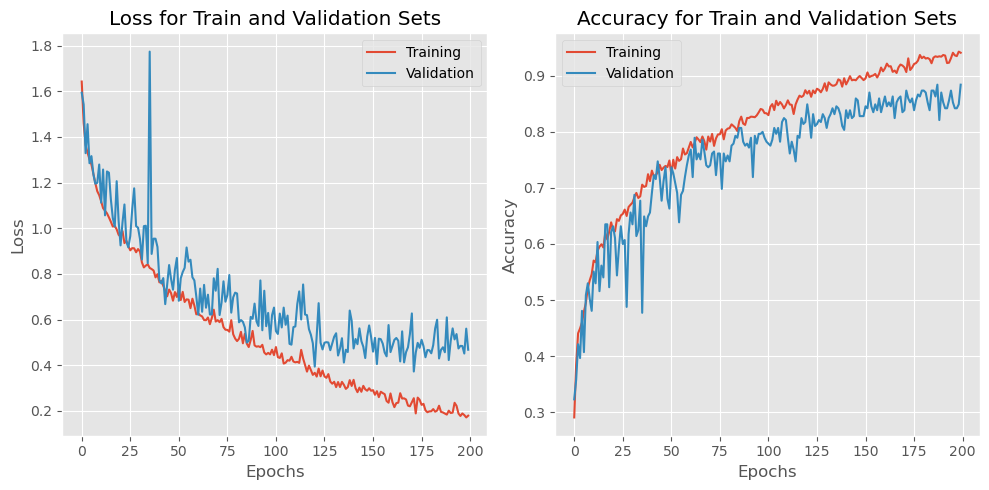

Males: 


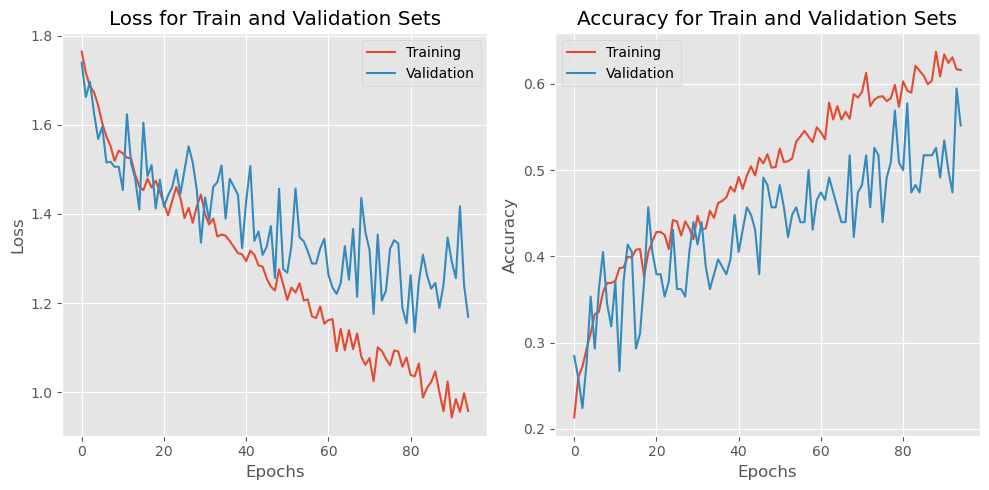

In [36]:
def create_training_history_plot(history):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].plot(history.history['loss'])
    axes[0].plot(history.history['val_loss'])
    axes[0].set_title('Loss for Train and Validation Sets')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend(['Training', 'Validation'])
    
    axes[1].plot(history.history['categorical_accuracy'])
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].set_title('Accuracy for Train and Validation Sets')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend(['Training', 'Validation'])
    
    fig.tight_layout()
    
    plt.show()

print("Females: ")
create_training_history_plot(history_female)

print("Males: ")
create_training_history_plot(history_male)

The performance discrepancy between gender-specific models emphasizes the need for expanded male voice representation to enhance cross-gender applicability.

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

9/9 [==============================] - 1s 18ms/step


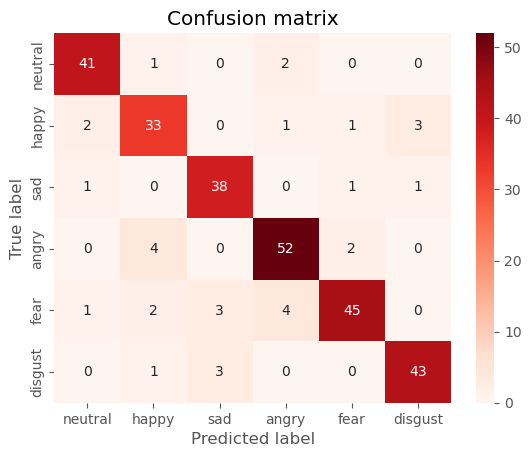

4/4 [==============================] - 1s 11ms/step


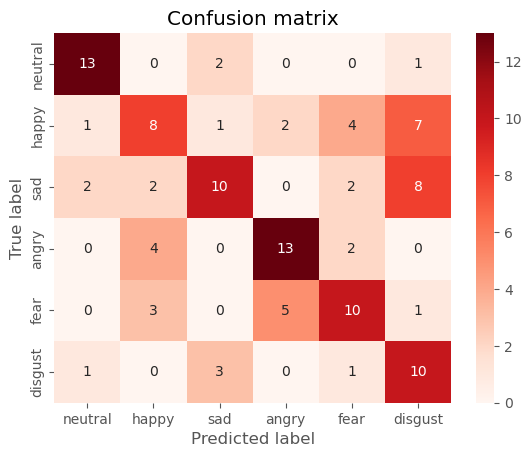

In [38]:
labels = ['neutral', 'happy', 'sad', 'angry', 'fear', 'disgust'] 

def create_confusion_matrix(model, X_val, y_val):
    features = model.predict(X_val)
    y_val_class = to_categorical(y_val, 6)
    y_pred = np.argmax(features, axis=1)
    y_true = np.argmax(y_val_class, axis=1)

    cm = confusion_matrix(y_true, y_pred, labels=range(6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')
    plt.show()


create_confusion_matrix(model_female, X_val_female, y_val_female)
create_confusion_matrix(model_male, X_val_male, y_val_male)

In [39]:
def create_classification_report(model, X_val, y_val):
    features = model.predict(X_val)
    y_val_class = to_categorical(y_val, 6)
    y_pred = np.argmax(features, axis=1)
    y_true = np.argmax(y_val_class, axis=1)
    
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    df = pd.DataFrame(report).transpose()
    print(df.round(3))

print("Female: ")
create_classification_report(model_female, X_val_female, y_val_female)

print("Male: ")
create_classification_report(model_male, X_val_male, y_val_male)

Female: 
9/9 [==============================] - 0s 19ms/step
              precision  recall  f1-score  support
neutral           0.911   0.932     0.921   44.000
happy             0.805   0.825     0.815   40.000
sad               0.864   0.927     0.894   41.000
angry             0.881   0.897     0.889   58.000
fear              0.918   0.818     0.865   55.000
disgust           0.915   0.915     0.915   47.000
accuracy          0.884   0.884     0.884    0.884
macro avg         0.882   0.886     0.883  285.000
weighted avg      0.885   0.884     0.884  285.000
Male: 
4/4 [==============================] - 0s 12ms/step
              precision  recall  f1-score  support
neutral           0.765   0.812     0.788   16.000
happy             0.471   0.348     0.400   23.000
sad               0.625   0.417     0.500   24.000
angry             0.650   0.684     0.667   19.000
fear              0.526   0.526     0.526   19.000
disgust           0.370   0.667     0.476   15.000
accuracy     

**Closing Remarks**

The models achieved approximately 88% validation accuracy on female voice samples and 55% on male voice samples. The performance differential highlights the importance of balanced gender representation in training datasets. Expanding the male voice corpus would likely improve model generalization across genders. The architecture demonstrates strong discriminative power when provided with sufficient training data and balanced representation across emotional categories.